# Logistic Regression and Random Forest: Medium.com employee data

In this notebook we continue the analysis of the human resources data provided by Medium on Kaggle (https://www.kaggle.com/ludobenistant/hr-analytics). It is simulated employee data of 15000 employees, and the goal is to understand something about what might cause an employee to prematurely leave the company.

The fact that we have some useful demographics about our employees, and that we know if the employee left or not means we can apply machine learning, and we can use supervised learning algorithms. One of the benefits of machine learning algorithms is you don't have to do any preliminary data exploration - the algorithm can decide for itself if a feature is relevant or not. As this is a classification problem (with two outcomes, will leave, or will stay) I will apply initially two classification algorithms: logistic regression, and random forest.

In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [3]:
from __future__ import print_function

In [4]:
sns.set_context("talk")

In [5]:
#data is comma-delimited csv, with headers in the first line
df = pd.read_csv('HR_comma_sep.csv')

In [6]:
#rename column sales to dept
df = df.rename(columns={'sales':'dept'})

In [7]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
dept                      object
salary                    object
dtype: object

In [8]:
#create dummy variables for columns that are categorical: dept, and salary
df = pd.get_dummies(df)
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'dept_IT', 'dept_RandD', 'dept_accounting',
       'dept_hr', 'dept_management', 'dept_marketing', 'dept_product_mng',
       'dept_sales', 'dept_support', 'dept_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

## General approaches

As we have labels that tell us what the real answer is, but we want to test our model as if it were encountering new data, it is common to divide the data into training and test subsets. A way to train and test, while subjecting all data to training and testing, is divide the data into equal parts, and cycle through these parts, where each cycle uses a different subset for testing. This is called a K-Fold cross validator, and the sci-kit learn package provides the indices for you. If your data has a greater percentage of a certain result value, you can ensure the ratio is consistent between folds using the sci-kit learn package StratifiedKFold.

## Logistic regression

Logistic regression is a simple algorithm, but is a powerhouse - many problems can be modeled with this technique. How well will it work for our data?

One thing to keep in mind is if some features are highly correlated, then the coefficients to those features may not be indicative of their true weight. For categorical data (department and salary) where the value must be one of n categories, the degrees of freedom is actually n-1; if you know the value for the first n-1 categories, the value for the nth category is deterministic. Therefore we delete one of the dummy columns per feature. Use of L1 regularization can help eliminate features that have very little impact on the churn variable. 

We will use L1 regularization to do feature elimination. We will also look at the correlation between features to get a sense of how many features we expect 

The process is as follows:
* process data so all formats are numeric - create dummy variables for categorical data (boolean yes/no for each category) (done above)
* use built-in tool (GridSearchCV) for optimizing fit parameters, like C which is the inverse regularization coefficient 
* split data into training and test data, use StratifiedKFold to retain ratio of each category intact in each fold, since data is a little unbalanced (roughly a quarter is labeled true)
* for each "fold", train the model, and then test. See which features have the most impact on the target variable, for each fold.
* calculate prediction metrics, such as:
 * confusion matrix (true positives, false positives, true negatives, false negatives)
 * plot the true positives rate vs the false positives rate, aka reciever operating characteristic (ROC) curve
 * precision-recall (PR) curve (great for unbalanced datasets since it ignores true negatives)
 * the area under the curve (AUC) for the ROC and PR curves (larger values are better) 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 

See how well default model fits to the data.

In [10]:
X = df.drop(['left','salary_medium','dept_IT'], axis=1).values
y = df.left.values
Xlabels = df.drop(['left','salary_medium','dept_IT'], axis=1).columns

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('Accuracy score of training set: {}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.7909825818818235
Accuracy score of test set: 0.7873333333333333


Tweak the input parameters, such as C, the inverse regularization coefficient.

In [12]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
Cs = [0.001, 0.1, 1, 10, 100, 1000, 10000]
lr = LogisticRegression(penalty='l1')
clf = GridSearchCV(lr, {'C':Cs})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {}'.format(clf.score(X, y)))

{'C': 10000}
Accuracy score: 0.7923194879658644


We now know what value of C provides a better score, though, it's not greatly different from score of the default value of C=1, so we will just use the default. Now we apply k-fold cross validation, to test out the stability of feature importance.

In [13]:
nfold = 5
y_test = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression(penalty='l1')

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_test[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(X[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

In [14]:
n_scor

array([ 0.79973342,  0.79366667,  0.80666667,  0.79193064,  0.65721907])

<IPython.core.display.Javascript object>


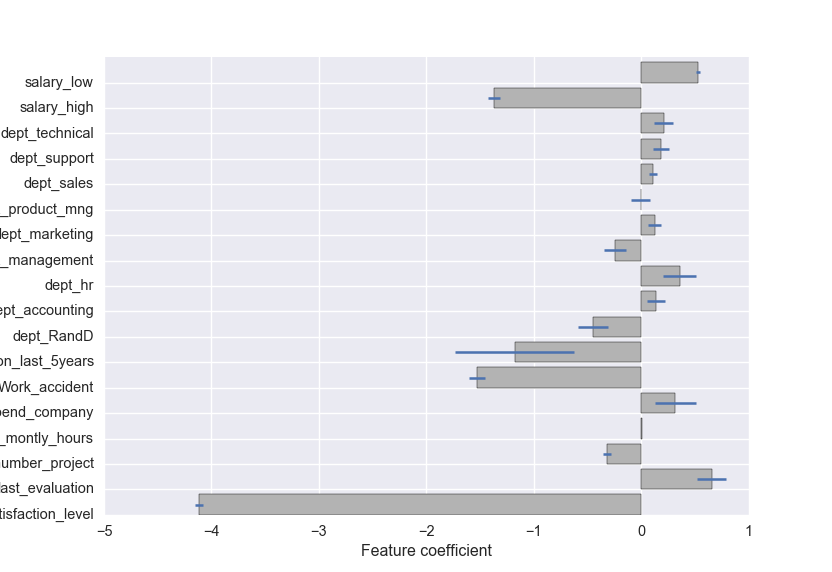

In [15]:
xerr=np.std(f_impo,axis=0)
plt.figure()
plt.barh(range(len(f_impo[0])),np.mean(f_impo,axis=0),xerr=xerr,color='0.7')
plt.yticks(range(len(f_impo[0])),Xlabels,rotation=0)
plt.xlabel('Feature coefficient')
plt.ylabel('Features')

In [17]:
confusion_matrix(y_test, y_pred)

array([[10235,  1193],
       [ 2259,  1312]])

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Compute ROC curve and area the curve
def plot_roc(y_test,y_score):
    lw = 2
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=lw,
             label='ROC')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve: AUC={0:0.2f}'.format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()
    
# Plot Precision-Recall curve
def plot_pr(y_test,y_score):
    lw = 2
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)

    plt.figure()
    plt.plot(recall, precision, lw=lw, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUC={0:0.2f}'.format(average_precision))
    #plt.legend(loc="lower left")
    plt.show()

<IPython.core.display.Javascript object>


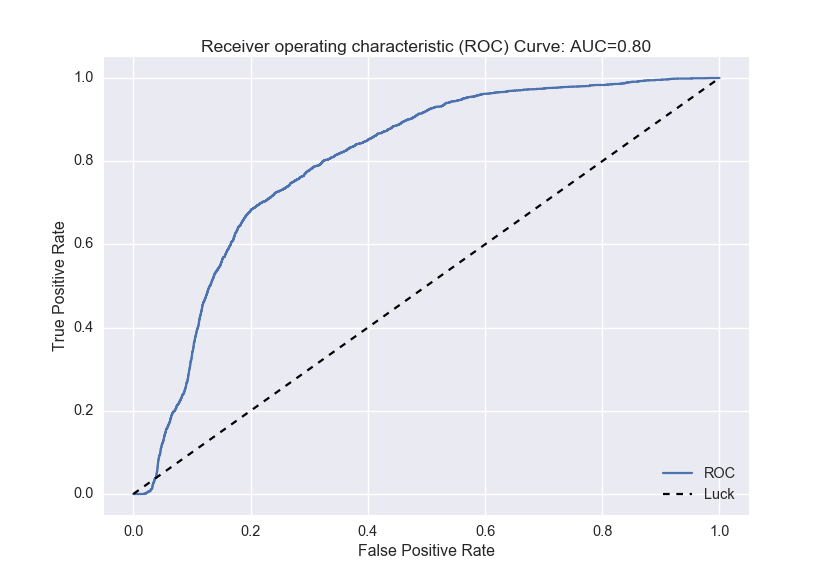

In [19]:
plot_roc(y_test,decfun)

<IPython.core.display.Javascript object>


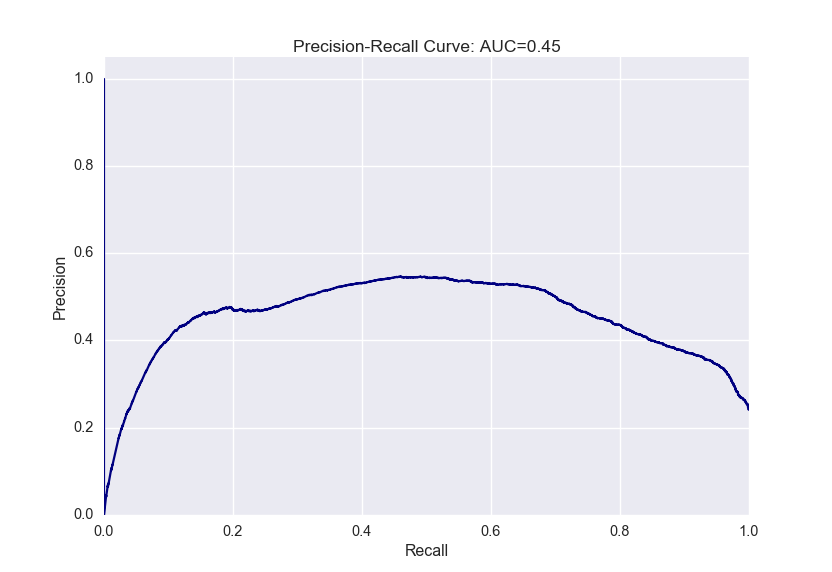

In [20]:
# Plot Precision-Recall curve
plot_pr(y_test,decfun)

### Second order, plus interaction terms

Logistic regression is a linear model - it is possible to fit non-linear behavior by adding features that are non-linear combinations of the original features. Here we do the fit with additional interaction terms.

In [21]:
from sklearn.preprocessing import PolynomialFeatures

In [22]:
poly = PolynomialFeatures(interaction_only=True)
Xinter = poly.fit_transform(X)
#poly.get_feature_names()

In [23]:
nfold = 5
y_test = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,Xinter.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression()

for train, test in StratifiedKFold(nfold).split(Xinter, y):
    clf.fit(Xinter[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(Xinter[test])
    y_test[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(Xinter[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(Xinter[test],y[test])
    offset += len(test)
    n += 1

In [24]:
n_scor

array([ 0.92769077,  0.918     ,  0.91466667,  0.92930977,  0.8396132 ])

<IPython.core.display.Javascript object>


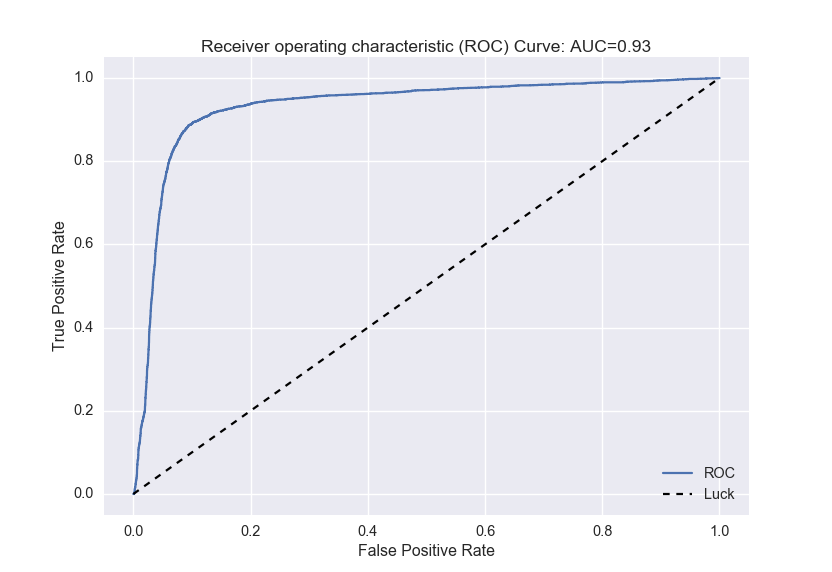

In [25]:
plot_roc(y_test,decfun)

<IPython.core.display.Javascript object>


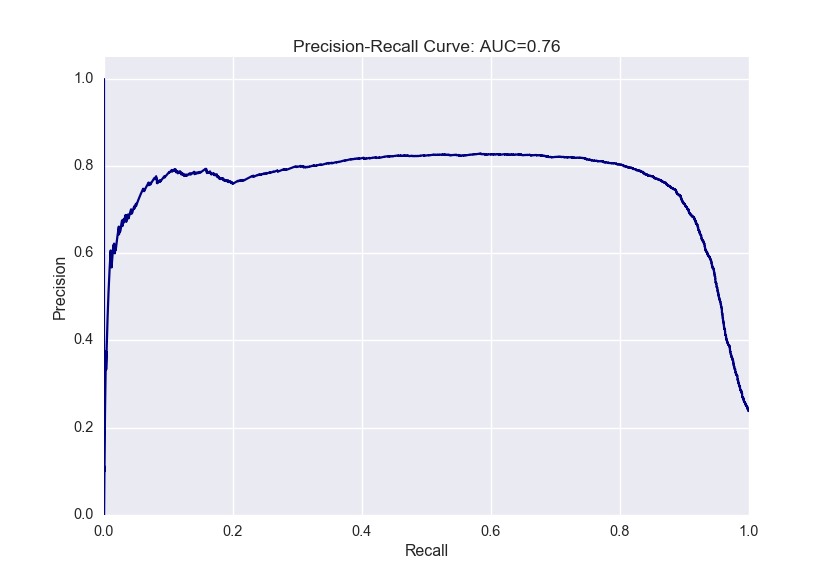

In [26]:
plot_pr(y_test,decfun)

The logistic regression predicted much better with the interaction terms. However the accuracy is only around 90%, and we would like to do better than that.

## Random Forest

Decision trees are fast, but prone to overfitting - hence the ensemble technique of random forest. While any one tree will not give us a sense of what are the most important features, which is one of the learnings desired from churn analysis - what changes need to be made to avoid churn - it can be a very good predictor.

As we have labels that tell us what the real answer is, but we want to test our model as if it were encountering new data, it is common to divide the data into training and test subsets. A way to train and test, while subjecting all data to training and testing, is divide the data into equal parts, and cycle through these parts, where each cycle uses a different subset for testing. This is called a K-Folds cross validator, and the sci-kit learn package provides the indices for you.

The process is as follows:
* process data so all formats are numeric - create dummy variables for categorical data (boolean yes/no for each category) (done above)
* split data into training and test data, use StratifiedKFold to retain ratio of each category intact in each fold, since data is a little unbalanced (roughly a quarter is labeled true)
* for each "fold", train the model, and then test
* try classifier with default values. if necessary, optimize fit parameters, like the number of estimators, criterion (gini or entropy), and minimum impurity split 
* calculate prediction metrics, such as:
 * confusion matrix (true positives, false positives, true negatives, false negatives)
 * plot the true positives rate vs the false positives rate, aka reciever operating characteristic (ROC) curve
 * precision-recall (PR) curve (great for unbalanced datasets since it ignores true negatives)
 * the area under the curve (AUC) for the ROC and PR curves (larger values are better) 
 
 
 
criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

In [28]:
X = df.drop('left', axis=1).values
y = df.left.values
Xlabels = df.drop(['left'], axis=1).columns

First, a quick check of how well the default model works on the data on a simple split of training and test data.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [30]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('Accuracy score of training set: {}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.9984165347112259
Accuracy score of test set: 0.9906666666666667


The fit is already very good, for the training and test set. Can the fit be tweaked even better? Use GridSearchCV to find best parameters.

In [31]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
nEs = [10, 100, 500]
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, {'n_estimators':nEs})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {}'.format(clf.score(X,y)))

{'n_estimators': 500}
Accuracy score: 1.0


In [32]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('Accuracy score of training set: {}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 1.0
Accuracy score of test set: 0.9896666666666667


In [33]:
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('Accuracy score of training set: {}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 1.0
Accuracy score of test set: 0.9906666666666667


With GridSearchCV, the greater number of estimators has better accuracy. Now, with KFold, to do cross validation, and look at stability of feature importance.

In [34]:
nfold = 5
y_test = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0

clf = RandomForestClassifier(n_estimators=500)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_test[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.predict_proba(X[test])[:,1]
    f_impo[n,:] = clf.feature_importances_
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

In [35]:
n_scor

array([ 0.99866711,  0.979     ,  0.98266667,  0.99866622,  0.99533178])

Now that we've run the 5-fold cross validation, let's take a look at the feature importance, and performance metrics. 

<IPython.core.display.Javascript object>


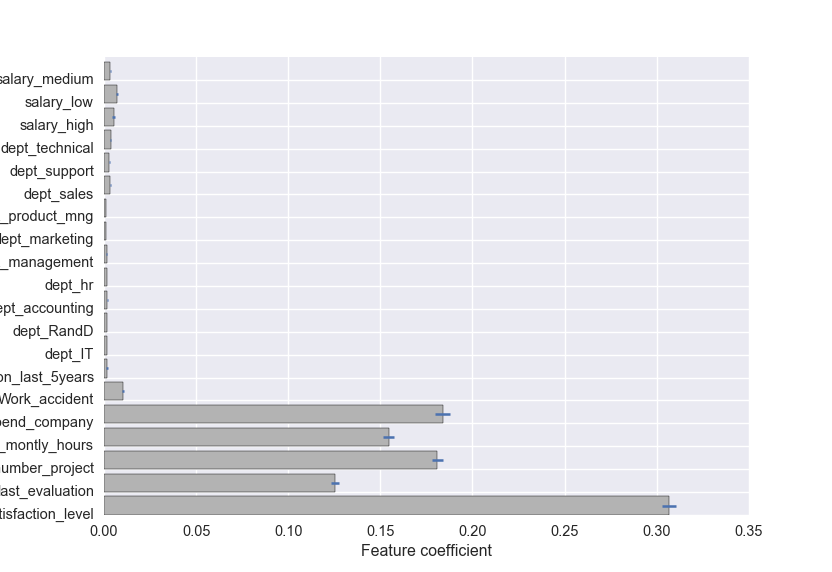

In [36]:
xerr=np.std(f_impo,axis=0)
plt.figure()
plt.barh(range(len(f_impo[0])),np.mean(f_impo,axis=0),xerr=xerr, color='0.7')
plt.yticks(range(len(f_impo[0])),Xlabels,rotation=0)
plt.xlabel('Feature coefficient')
plt.ylabel('Features')

The features that are most important are satisfaction level, last evaluation, number of projects, average monthly hours, and time spent at the company. You can see below that the accuracy is very good using random forest on this data. The areas under the curve for both the ROC and Precision-recall curves are 0.99.

In [37]:
confusion_matrix(y_test, y_pred)

array([[11389,    39],
       [   98,  3473]])

<IPython.core.display.Javascript object>


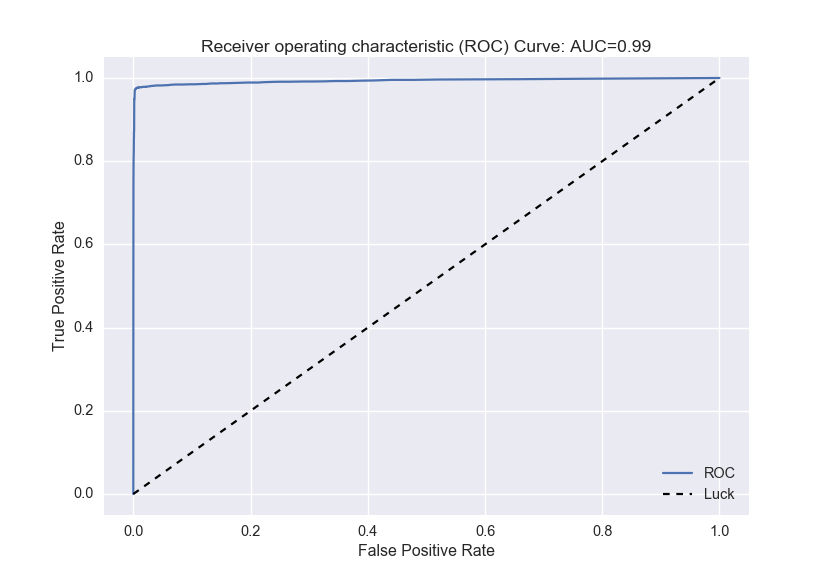

In [38]:
plot_roc(y_test,decfun)

<IPython.core.display.Javascript object>


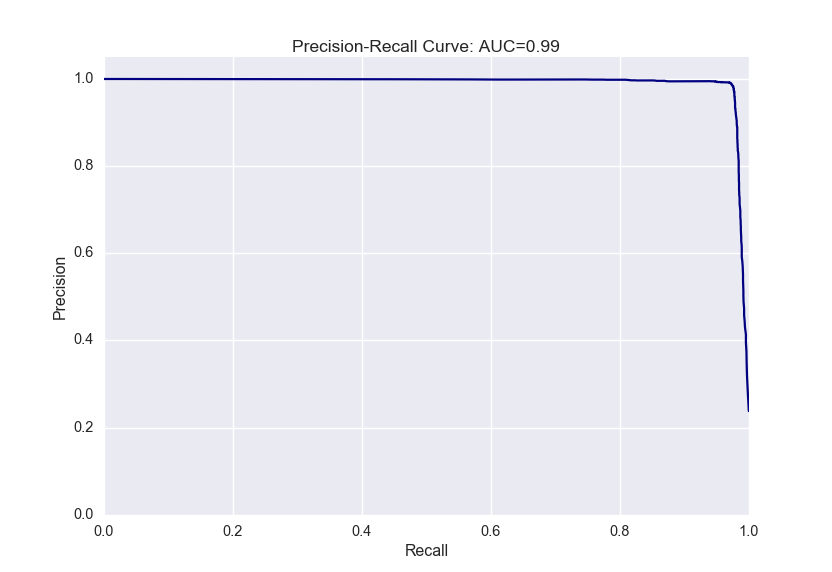

In [39]:
# Plot Precision-Recall curve
plot_pr(y_test,decfun)